# Download and save data with the Rune API

This template walks through a simple example of downloading raw time series and spectrogram data, given some time interval of interest. For other API endpoints, check out the full API documentation at: https://rune-labs.quip.com/O04sAHmIkRA6/Rune-Stream-API-v1-Patient-Side-Access

With the downloaded raw time series, we will also locally compute our own spectrogram and compare to the API spectrogram.

In [1]:
import requests
import pandas as pd
import numpy as np
from scipy import stats
from scipy import signal
import matplotlib.pyplot as plt

## Functions for pulling raw time series and spectrogram data with the API

`get_neural_time_series` and `get_spectrogram` are two wrapper functions that will pull data with the API and save as CSVs. These wrapper functions can be easily modified to access the other API endpoints.

In [2]:
def get_neural_time_series(start_time, end_time, channel, key_id, key_secret, device_id, save_directory):
    '''
    Retrieves raw time series between two time stamps and saves data to a csv

    Input:
        start_time and end_time as unix time stamps
        channel, a comma separated string with channel number(s). ex: '0' or '0,1,2,3'
        API credentials
        save_directory, file path for saving csv
    '''

    url = "https://stream.runelabs.io/v1/lfp.csv"
    headers = {
        'X-Rune-Client-Key-ID': key_id,
        'X-Rune-Client-Access-Key': key_secret
    }
    params = {
        'channels': channel,
        'device_id': device_id,
        'start_time': start_time,
        'end_time': end_time,
        'timestamp': 'unix',
    }

    with requests.get(url, headers=headers, params=params, stream=True) as r:
        r.raise_for_status()

        with open(save_directory, 'wb') as f:
            for chunk in r.iter_content(chunk_size=8192):
                f.write(chunk)

def get_spectrogram(start_time, end_time, channel, key_id, key_secret, device_id, save_directory):
    '''
    Retrieves raw time series between two time stamps and saves data to a csv

    Input:
        start_time and end_time as unix time stamps
        channel, a string with a single channel number
        API credentials
        save_directory, file path for saving csv
    '''

    url = "https://stream.runelabs.io/v1/lfp.csv"
    headers = {
        'X-Rune-Client-Key-ID': key_id,
        'X-Rune-Client-Access-Key': key_secret
    }
    params = {
        'channels': channel,
        'device_id': device_id,
        'start_time': start_time,
        'end_time': end_time,
        'timestamp': 'unix',
        'expression': 'spectrogram(lfp)'
    }

    with requests.get(url, headers=headers, params=params, stream=True) as r:
        r.raise_for_status()

        with open(save_directory, 'wb') as f:
            for chunk in r.iter_content(chunk_size=8192):
                f.write(chunk)


## 1. Initialize API credentials

First initialize your API credentials. These credentials are analogous to having a username/password for accessing patient data. You will set up a 'Client' to access data for each patient, and each Client has its own ID and secret. 

- Navigate to the web app (https://app.runelabs.io/patients) as an **admin** user
- Click the pencil next to the patient of interest
- Open the Clients section and create a new Client. Copy the ID and secret (these will only be shown once)
- Open the Devices section to find the device IDs.

In the code below, replace `%env ...` with your own credential strings. For example, replace `%env rcs07_key_id` with `'ABCDEFG'`. To keep API credentials private for code sharing, the strings can be saved and accessed as environment variables, as they are below.

In [3]:
# load api credentials

key_id = %env rcs07_key_id
key_secret = %env rcs07_key_secret
device_id = %env rcs07_device_id_right

## 2. Specify time interval of interest and retrieve data

Currently, requests for long durations of data will time out (in the future, larger requests will be paginated). To download data for more than 1 day, partition into multiple smaller requests.

Be sure to change `save_directory` to an appropriate file path on your computer. For Windows users, add `r` in front of the path.

In [4]:
start_time = 1584646104.275  # unix time stamp
end_time = 1584647285.888    # unix time stamp

get_spectrogram(start_time, end_time, '0', key_id, key_secret, device_id, '/Users/witney/Documents/rune_data/rcs07_sample_spectro')
get_neural_time_series(start_time, end_time, '0', key_id, key_secret, device_id, '/Users/witney/Documents/rune_data/rcs07_sample_time_series')

If you do not know the unix time stamps, you can convert from date time. For example:
```
start_time = datetime.datetime(2019, 1, 1).timestamp()
end_time = datetime.datetime(2019, 1, 12).timestamp()
```

## 3. Load CSV's and clean dataframes

Next, we will load the spectrogram and time series as dataframes. We will locally compute our own spectrogram and compare to the API output. Be sure to change the file path to the appropropriate path.

In [5]:
spectro = pd.read_csv('/Users/witney/Documents/rune_data/rcs07_sample_spectro')
time_series = pd.read_csv('/Users/witney/Documents/rune_data/rcs07_sample_time_series')

The `spectro` dataframe is organized with one frequency per column and one time point per row. `timestamp` gives the unix time stamp for the corresponding power values. If converted to date time format, note that UTC time will need to be adjusted to the appropriate time zone. 

In [6]:
spectro

,timestamp,f.0hz,f.1hz,f.2hz,f.3hz,f.4hz,f.5hz,f.6hz,f.7hz,f.8hz,...,f.90hz,f.91hz,f.92hz,f.93hz,f.94hz,f.95hz,f.96hz,f.97hz,f.98hz,f.99hz
0,1.584646e+09,6.115595e-13,5.458663e-11,2.658079e-12,1.433219e-12,4.607640e-12,5.706380e-13,1.878613e-12,5.572002e-12,1.412470e-12,...,1.738257e-15,1.025110e-13,6.703864e-14,1.234224e-13,2.395165e-14,6.001970e-15,1.785271e-15,5.312263e-14,1.398121e-14,1.952270e-14
1,1.584646e+09,2.439943e-14,1.697798e-11,7.921616e-12,4.039895e-12,6.249358e-14,3.324127e-13,2.137339e-12,5.524374e-12,9.157283e-12,...,5.475237e-14,1.558918e-14,1.117521e-13,1.067700e-14,2.014926e-14,1.456969e-13,7.536462e-15,3.588288e-14,1.399365e-13,2.274190e-14
2,1.584646e+09,7.054069e-14,5.370560e-12,1.017927e-11,2.607148e-12,1.950424e-12,6.598222e-13,9.528701e-13,4.306778e-14,7.234965e-13,...,1.215273e-14,5.092057e-14,5.310998e-14,2.552551e-14,1.530412e-14,2.862943e-14,5.000783e-14,1.209821e-14,1.408963e-14,9.756991e-14
3,1.584646e+09,1.209511e-12,3.560191e-13,1.561056e-11,1.681320e-11,8.558831e-13,6.401173e-12,1.285776e-11,1.409356e-13,6.952712e-12,...,1.648224e-13,4.531006e-15,4.884526e-14,4.484343e-14,1.257481e-14,1.285461e-13,5.095837e-14,1.074869e-13,8.964205e-14,4.602956e-14
4,1.584646e+09,5.364149e-17,2.532073e-11,2.874898e-12,1.286921e-12,7.763988e-13,2.120151e-12,9.253399e-13,4.478959e-12,4.156628e-12,...,3.667917e-14,2.641166e-14,2.302297e-14,4.873151e-15,1.790194e-14,7.564916e-14,5.053770e-15,3.727955e-15,7.772566e-15,4.629188e-14
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
1343,1.584647e+09,4.492965e-12,4.326021e-11,2.709557e-11,6.252064e-12,7.199383e-12,2.152703e-13,3.975614e-12,4.341340e-12,1.609024e-12,...,3.797986e-15,5.434245e-15,5.742178e-14,2.810809e-14,1.340800e-13,5.742115e-14,1.537192e-13,1.533477e-14,6.580756e-14,2.769258e-14
1344,1.584647e+09,6.125107e-13,4.515990e-12,5.189037e-11,3.746071e-11,2.689727e-11,5.857316e-12,3.255483e-11,1.272299e-11,2.776645e-12,...,2.692574e-14,4.960188e-18,5.350081e-14,9.328355e-14,2.954021e-13,1.156088e-14,1.083001e-14,1.821710e-14,2.650849e-14,2.419729e-16
1345,1.584647e+09,8.543984e-16,1.678674e-11,5.088754e-12,1.046699e-13,3.918579e-12,8.063465e-13,1.648498e-12,9.365996e-14,1.086757e-11,...,6.181038e-15,1.431811e-13,9.219183e-15,2.918604e-14,2.365736e-15,6.552673e-15,7.536829e-14,1.175478e-14,8.427066e-15,3.952399e-14
1346,1.584647e+09,1.292656e-15,5.759595e-11,7.157589e-11,4.268846e-13,5.183632e-12,2.491758e-12,7.249853e-12,3.406889e-12,9.460136e-12,...,3.519647e-14,8.466194e-15,2.447196e-14,3.103961e-14,4.987424e-16,4.712850e-14,2.104293e-14,4.406281e-14,1.176596e-14,2.494635e-14


`time_series` is organized with channels as the columns and time points for each row. In this example, we pulled data for channel 0, but we can pull all four time series simultaneously if the `channel` parameter is changed to `'0,1,2,3'`. Spectrograms can only be pulled for one channel at a time.

In [7]:
time_series

,timestamp,channel.0
0,1.584646e+09,-0.000172
1,1.584646e+09,-0.000161
2,1.584646e+09,-0.000164
3,1.584646e+09,-0.000154
4,1.584646e+09,-0.000167
...,...,...
294998,1.584647e+09,-0.000185
294999,1.584647e+09,-0.000178
295000,1.584647e+09,-0.000194
295001,1.584647e+09,-0.000183


### API spectrogram

Next we will generated some cleaned arrays for plotting the API spectrogram.

In [8]:
# create an array with only the power values
Sxx_api = spectro.drop(labels=['timestamp','f.0hz'],axis=1).values
Sxx_api = Sxx_api.transpose()

# z-score for plotting (optional)
Sxx_api = stats.zscore(Sxx_api, axis=0)

# obtain frequencies from column headers, drop 0 hz
f_api = [int(''.join(i for i in freq if i.isdigit())) for freq in list(spectro.keys()[1:])]
f_api = f_api[1:]

# change unix to date time stamps for plotting
t_api = pd.to_datetime(spectro.timestamp, unit='s')

### API time series

Here we will locally compute a spectrogram from the raw time series.

In [9]:
f_calc, t_calc, Sxx_calc = signal.spectrogram(time_series['channel.0'],fs=250,nperseg=250)

# z-score transform for plotting (optional)
Sxx_calc = stats.zscore(Sxx_calc, axis=0)

# specify time stamps for plotting
# note: these time stamps will not be accurate if there are gaps in the data
# next notebooks will cover how to identify data gaps
step_size = (end_time-start_time)/len(t_calc)
t_calc = np.arange(start_time,end_time,step_size)
t_calc = pd.to_datetime(t_calc, unit='s')

## 4. Plot API spectrogram and locally computed spectrogram

Note: In this notebook, plots are static. Use magic function `%matplotlib notebook` for interactive zooming and panning.

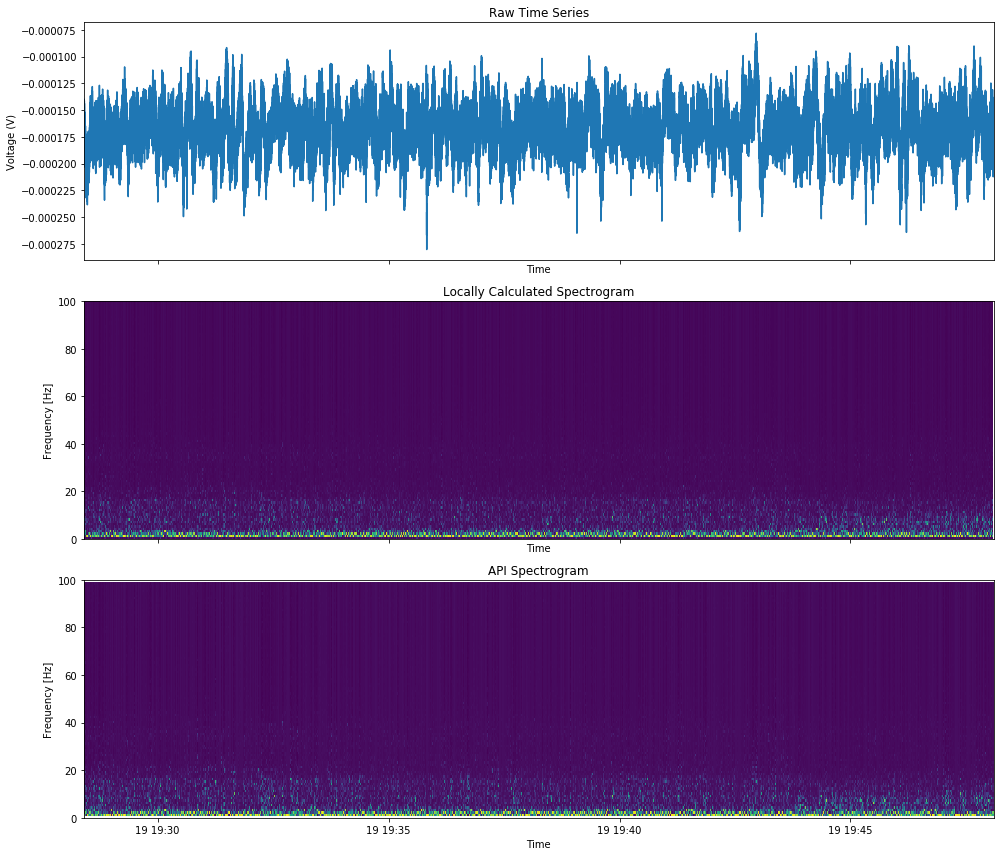

In [10]:
fig, ax = plt.subplots(3,figsize=(14,12), sharex=True)

ax[0].plot(pd.to_datetime(time_series.timestamp, unit='s'), time_series['channel.0'])
ax[0].set(xlabel='Time',ylabel='Voltage (V)')
ax[0].set_title('Raw Time Series')

ax[1].pcolormesh(t_calc, f_calc, Sxx_calc)
ax[1].set(xlabel='Time',ylabel='Frequency [Hz]')
ax[1].set_title('Locally Calculated Spectrogram')
ax[1].set_ylim([0,100])

ax[2].pcolormesh(t_api, f_api, Sxx_api)
ax[2].set(xlabel='Time',ylabel='Frequency [Hz]')
ax[2].set_title('API Spectrogram')
ax[2].set_ylim([0,100])

plt.tight_layout()

## Summary

Using the Rune API, we obtained raw time series and spectrogram data for a time interval of interest. 

To find relevant data epochs and their timestamps, check out the next notebook `filter_by_meta_data`.